# 5. How to Log and Visualize Simulations

Here we explain how to take a log of simulation results and how to visualize it. 

In [1]:
%matplotlib inline
import math
from ecell4 import *

## 5.1. Logging Simulations with Observers

E-Cell4 provides special classes for logging, named `Observer`. `Observer` class is given when you call the `run` function of `Simulator`.

In [2]:
def create_simulator(f=gillespie.GillespieFactory()):
    m = NetworkModel()
    A, B, C = Species('A', '0.005', '1'), Species('B', '0.005', '1'), Species('C', '0.005', '1')
    m.add_reaction_rule(create_binding_reaction_rule(A, B, C, 0.01))
    m.add_reaction_rule(create_unbinding_reaction_rule(C, A, B, 0.3))
    w = f.create_world()
    w.bind_to(m)
    w.add_molecules(C, 60)
    sim = f.create_simulator(w)
    sim.initialize()
    return sim

One of most popular `Observer` is `FixedIntervalNumberObserver`, which logs the number of molecules with the given time interval. `FixedIntervalNumberObserver` requires an interval and a list of serials of `Species` for logging.

In [3]:
obs1 = FixedIntervalNumberObserver(0.1, ['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)

`data` function of `FixedIntervalNumberObserver` returns the data logged.

In [4]:
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.1, 2.0, 2.0, 58.0], [0.2, 4.0, 4.0, 56.0], [0.30000000000000004, 5.0, 5.0, 55.0], [0.4, 5.0, 5.0, 55.0], [0.5, 6.0, 6.0, 54.0], [0.6000000000000001, 7.0, 7.0, 53.0], [0.7000000000000001, 9.0, 9.0, 51.0], [0.8, 10.0, 10.0, 50.0], [0.9, 11.0, 11.0, 49.0], [1.0, 12.0, 12.0, 48.0]]


`targets()` returns a list of `Species`, which you specified as an argument of the constructor.

In [5]:
print([sp.serial() for sp in obs1.targets()])

[u'A', u'B', u'C']


`NumberObserver` logs the number of molecules after every steps when a reaction occurs. This observer is useful to log all reactions, but not available for `ode`.

In [6]:
obs1 = NumberObserver(['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.04621197690981169, 1.0, 1.0, 59.0], [0.09764054799344776, 2.0, 2.0, 58.0], [0.3898574953041032, 3.0, 3.0, 57.0], [0.44605112413922116, 4.0, 4.0, 56.0], [0.47097062080036123, 5.0, 5.0, 55.0], [0.5243156747352213, 6.0, 6.0, 54.0], [0.5583703679053457, 7.0, 7.0, 53.0], [0.7720401665811105, 8.0, 8.0, 52.0], [0.889308294580432, 7.0, 7.0, 53.0], [0.9437109567849834, 6.0, 6.0, 54.0], [0.9462880985043365, 7.0, 7.0, 53.0], [0.9476789054110526, 8.0, 8.0, 52.0], [0.9626070189812433, 9.0, 9.0, 51.0], [1.0, 9.0, 9.0, 51.0]]


`TimingNumberObserver` allows you to give the times for logging as an argument of its constructor.

In [7]:
obs1 = TimingNumberObserver([0.0, 0.1, 0.2, 0.5, 1.0], ['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.1, 2.0, 2.0, 58.0], [0.2, 4.0, 4.0, 56.0], [0.5, 6.0, 6.0, 54.0], [1.0, 11.0, 11.0, 49.0]]


`run` function accepts multile `Observer`s at once.

In [8]:
obs1 = NumberObserver(['C'])
obs2 = FixedIntervalNumberObserver(0.1, ['A', 'B'])
sim = create_simulator()
sim.run(1.0, [obs1, obs2])
print(obs1.data())
print(obs2.data())

[[0.0, 60.0], [0.04621197690981169, 59.0], [0.09764054799344776, 58.0], [0.15538810089883473, 57.0], [0.17997417788388045, 56.0], [0.23325151644441383, 55.0], [0.49413560843731574, 54.0], [0.5677450690656852, 53.0], [0.6021892176945252, 52.0], [0.6514055175551001, 51.0], [0.7556959972268968, 50.0], [0.8996298677027648, 49.0], [0.9004200446141566, 48.0], [0.9688629284862074, 47.0], [0.9811683985097295, 48.0], [1.0, 48.0]]
[[0.0, 0.0, 0.0], [0.1, 2.0, 2.0], [0.2, 4.0, 4.0], [0.30000000000000004, 5.0, 5.0], [0.4, 5.0, 5.0], [0.5, 6.0, 6.0], [0.6000000000000001, 7.0, 7.0], [0.7000000000000001, 9.0, 9.0], [0.8, 10.0, 10.0], [0.9, 11.0, 11.0], [1.0, 12.0, 12.0]]


`FixedIntervalHDF5Observedr` logs the whole data in a `World` to an output file with the fixed interval. Its second argument is a prefix for output filenames. `filename()` returns the name of a file scheduled to be saved next. At most one format string like `%02d` is allowed to use a step count in the file name. When you do not use the format string, it overwrites the latest data to the file.

In [9]:
obs1 = FixedIntervalHDF5Observer(0.2, 'test%02d.h5')
print(obs1.filename())
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.filename())

test00.h5
test06.h5


In [10]:
w = load_world('test05.h5')
print(w.t(), w.num_molecules(Species('C')))

(1.0, 49)


The usage of `FixedIntervalCSVObserver` is almost same with that of `FixedIntervalHDF5Observer`. It saves positions (x, y, z) of particles with the radius (r) and serial number of `Species` (sid) to a CSV file.

In [11]:
obs1 = FixedIntervalCSVObserver(0.2, "test%02d.csv")
print(obs1.filename())
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.filename())

test00.csv
test06.csv


Here is the first 10 lines in the output CSV file.

In [12]:
print(''.join(open("test05.csv").readlines()[: 10]))

x,y,z,r,sid
0.4539691770914942,0.15462163137272,0.025938569335266948,0,0
0.63902121409773827,0.92383170709945261,0.48188442294485867,0,0
0.1389003568328917,0.16998347686603665,0.10965284937992692,0,0
0.33477636775933206,0.10416981065645814,0.17564201261848211,0,0
0.86008434370160103,0.1050657273735851,0.43960539507679641,0,0
0.66850496688857675,0.35306781181134284,0.67028418160043657,0,0
0.88849738845601678,0.87646292988210917,0.26707155560143292,0,0
0.36764588067308068,0.15032237558625638,0.13349779113195837,0,0
0.34609787538647652,0.050046837190166116,0.14193614828400314,0,0



For particle simulations, E-Cell4 also provides `Observer` to trace a trajectory of a molecule, named `FixedIntervalTrajectoryObserver`. When no `ParticleID` is specified, it logs all the trajectories. Once some `ParticleID` is lost for the reaction during a simulation, it just stop to trace the particle any more.

In [13]:
sim = create_simulator(spatiocyte.SpatiocyteFactory(0.005))
obs1 = FixedIntervalTrajectoryObserver(0.01)
sim.run(0.1, obs1)

In [14]:
print([tuple(pos) for pos in obs1.data()[0]])

[(0.6368673331236264, 0.23382685902179845, 0.135), (0.6123724356957946, 0.2107328482542134, 0.28500000000000003), (0.530722777603022, 0.2107328482542134, 0.41500000000000004), (0.6695271963607354, 0.3637306695894642, 0.29), (0.4082482904638631, 0.2598076211353316, 0.26)]


Generally, `World` assumes a periodic boundary for each plane. To avoid the big jump of a particle at the edge due to the boundary condition, `FixedIntervalTrajectoryObserver` tries to keep the shift of positions. Thus, the positions stored in the `Observer` are not necessarily limited in the cuboid given for the `World`. To track the diffusion over the boundary condition accurately, the step interval for logging must be small enough. Of course, you can disable this option. See `help(FixedIntervalTrajectoryObserver)`.

## 5.2. Visualization of Data Logged

In this section, we explain the visualization tools for data logged by `Observer`.

Firstly, for time course data, `viz.plot_number_observer` plots the data provided by `NumberObserver`, `FixedIntervalNumberObserver` and `TimingNumberObserver`. For the detailed usage of `viz.plot_number_observer`, see `help(viz.plot_number_observer)`.

In [15]:
obs1 = NumberObserver(['C'])
obs2 = FixedIntervalNumberObserver(0.1, ['A', 'B'])
sim = create_simulator()
sim.run(10.0, [obs1, obs2])

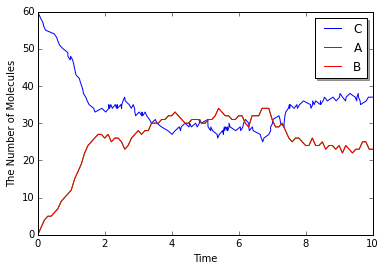

In [16]:
viz.plot_number_observer(obs1, obs2)

You can set the style for plotting, and even add an arbitrary function to plot.

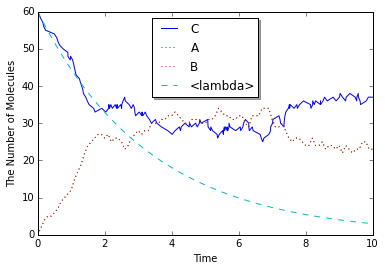

In [17]:
viz.plot_number_observer(obs1, '-', obs2, ':', lambda t: 60 * math.exp(-0.3 * t), '--')

Plotting in the phase plane is also available by specifing the x-axis and y-axis.

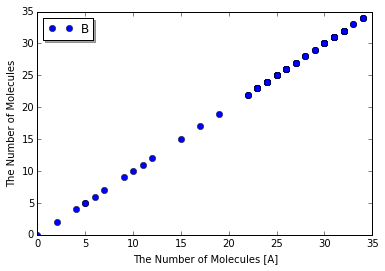

In [18]:
viz.plot_number_observer(obs2, 'o', x='A', y='B')

For spatial simulations, to visualize the state of `World`, `viz.plot_world` is available. This function plots the points of particles in three-dimensional volume in the interactive way. You can save the image by clicking a right button on the drawing region.

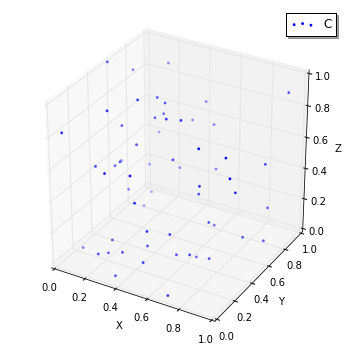

In [19]:
sim = create_simulator(spatiocyte.SpatiocyteFactory(0.005))
# viz.plot_world(sim.world())
viz.plot_world(sim.world(), interactive=False)

You can also make a movie from a series of HDF5 files, given as a `FixedIntervalHDF5Observer`. NOTE: `viz.plot_movie` requires an extra library, `ffmpeg`, when `interactive=False`.

In [20]:
sim = create_simulator(spatiocyte.SpatiocyteFactory(0.005))
obs1 = FixedIntervalHDF5Observer(0.02, 'test%02d.h5')
sim.run(1.0, obs1)
viz.plot_movie(obs1)

Start generating species_list ...
Start preparing mplot3d ...
Start making animation ...
Start generating a movie ...


Finally, corresponding to `FixedIntervalTrajectoryObserver`, `viz.plot_trajectory` provides a visualization of particle trajectories.

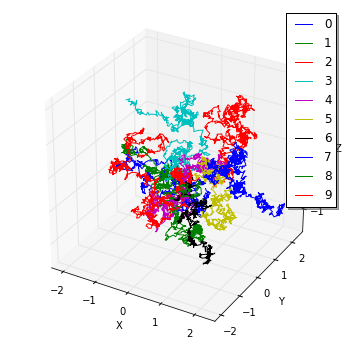

In [21]:
sim = create_simulator(spatiocyte.SpatiocyteFactory(0.005))
obs1 = FixedIntervalTrajectoryObserver(1e-3)
sim.run(1, obs1)
# viz.plot_trajectory(obs1)
viz.plot_trajectory(obs1, interactive=False)